# Telecom Churn Prediction

* [Introduction](#Introduction)
* [Dataset exploration](#Dataset-exploration)
* [Baseline models for churn classification](#Baseline-models-for-churn-classification)
* [Explainig models](#Explainig-models)
* [Uplift models](#Uplift-models)
* [Take out](#Take-out)

### Importing libraries

In [2]:
#loading libraries for data analysis
import pandas as pd
import numpy as np


import pickle

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

In [ ]:
#loading statistical libraries and confssion matrix
from sklearn.metrics import confusion_matrix
import pingouin as pg

In [3]:
# loading original data
data = pd.read_csv('data/telecom_churn.csv')
# loading data after preprocessing - standardization and one hot encoding
data_processed = pd.read_csv('data/telecom_churn_processed.csv')

## Introduction

Every company wants to provide best services to their customers. One way to learn how to improve the quality of the provide service and satisfies users is to learn why they are leaving the company. Another term for that phenomena is churn rate. In this notebook, I will try to understand why certain users are leaving the provider. I'm using kaggle dataset [Customer Churn](https://www.kaggle.com/datasets/barun2104/telecom-churn) for this task. Therefore, I will build machine learning models to classify users that are likely to leave. 

If possible, I will try to find an efficient way to reach out to those users and try to convince them to stay. In other ways, I will try to find out what are the most important features that are related to churn. And I will try myself in uplift modelling.

**Research questions**
- What are the most important features that are related to churn?
- Can we build a model that will predict churn?
- Can we learn which feature change to provide better service for customers and have higher retain rate?
- What action should be taken to prevent churn?

## Dataset exploration

### EDA

Dataset consist of 13 variables and, 3333 rows. There are 3 types of variables: categorical, numerical and binary. **Churn** is our target variable. It is a binary variable with values 0 and 1. 0 means that user is still with the company, and 1 means that user has left the company.

There are 2 categorical variables: Contract Renewal, Data Plan.

The rest of the data (10 rows) is numerical.

In [ ]:
data.head(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2


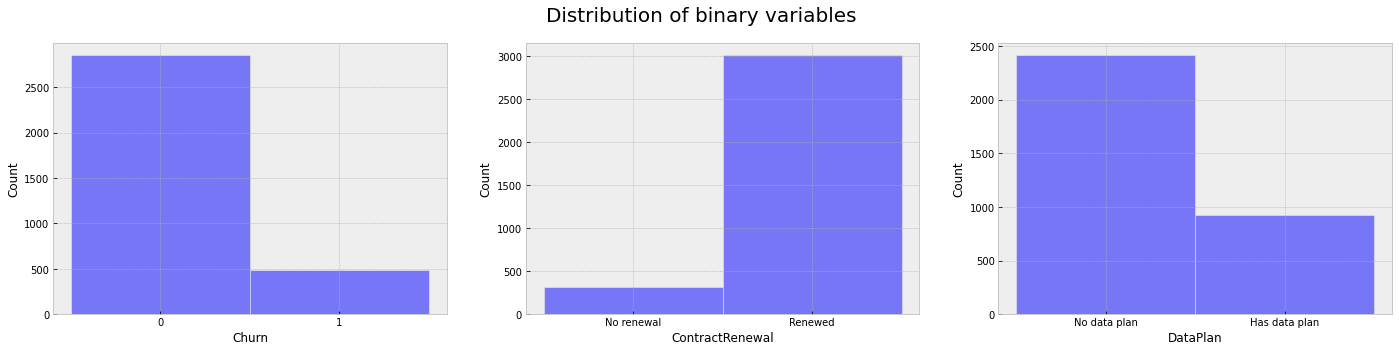

In [ ]:
fig, ax = plt.subplots( 1,3, figsize=(24, 5))
plt.suptitle('Distribution of binary variables', fontsize=20)

sns.histplot(data['Churn'],discrete=True,ax=ax[0], alpha = 0.5)
ax[0].set_xticks([0,1]);

sns.histplot(data['ContractRenewal'],discrete=True, ax=ax[1], alpha = 0.5)
ax[1].set_xticks([0,1],['No renewal','Renewed']);

sns.histplot(data['DataPlan'],discrete=True, ax=ax[2], alpha = 0.5)
ax[2].set_xticks([0,1],['No data plan','Has data plan']);

In [4]:
len(data[data['ContractRenewal']==1]) / len(data) # contract renewal rate

0.903090309030903

- Dataset is poorly balanced users that churned contribute to 15% of the dataset. Stratification and balancing trainig sets is strongly adiviced.
- Contract renewal means that userhas recently renewed contract with the company. It is not clear what is the time period of the contract.
- 28% of the users besides having regular phone service have alse internet acces via smarphone.

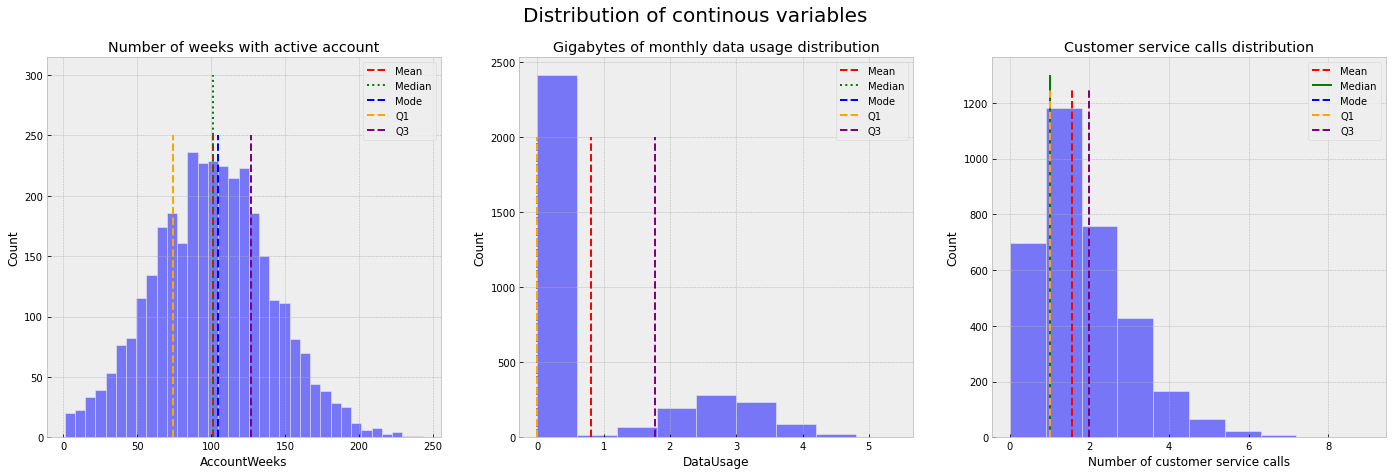

In [32]:
fig, ax = plt.subplots( 1,3, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['AccountWeeks'],ax=ax[0], alpha = 0.5)
ax[0].set_title('Number of weeks with active account')
ax[0].vlines(data['AccountWeeks'].mean(),0,250,color='red',label='Mean' , linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].median(),0,300,color='green',label='Median', linestyles='dotted')
ax[0].vlines(data['AccountWeeks'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();


sns.histplot(data['DataUsage'],bins=9,ax=ax[1], alpha = 0.5)
ax[1].set_title('Gigabytes of monthly data usage distribution')
ax[1].vlines(data['DataUsage'].mean(),0,2000,color='red',label='Mean' , linestyles='dashed')
ax[1].vlines(data['DataUsage'].median(),0,2000,color='green',label='Median', linestyles='dotted')
ax[1].vlines(data['DataUsage'].mode()[0],0,2000,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['DataUsage'].quantile(0.25),0,2000,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['DataUsage'].quantile(0.75),0,2000,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();


sns.histplot(data['CustServCalls'],bins=10, ax = ax[2], alpha = 0.5)
ax[2].set_title('Customer service calls distribution')
ax[2].vlines(data['CustServCalls'].mean(),0,1250,color='red',label='Mean' , linestyles='dashed')
ax[2].vlines(data['CustServCalls'].median(),0,1300,color='green',label='Median', linestyles='solid')
ax[2].vlines(data['CustServCalls'].mode()[0],0,1250,color='blue',label='Mode', linestyles='dashed')
ax[2].vlines(data['CustServCalls'].quantile(0.25),0,1250,color='orange',label='Q1', linestyles='dashed')
ax[2].vlines(data['CustServCalls'].quantile(0.75),0,1250,color='purple',label='Q3', linestyles='dashed')
ax[2].set_xlabel('Number of customer service calls')
ax[2].legend();

- Average of active contract is 101 weeks (around 23 months). Most contracts lifespan is between 74 weeks and 127 weeks (around 17 months and 29 months).
- Since most users doesn't have data plan data usage variable have most it's variable around 0.
- Customer service calls is highly skewed. Most users have 1 or 2 customer service calls. There are some users with more than 4 calls. It's plausible that those users are more likely to churn.

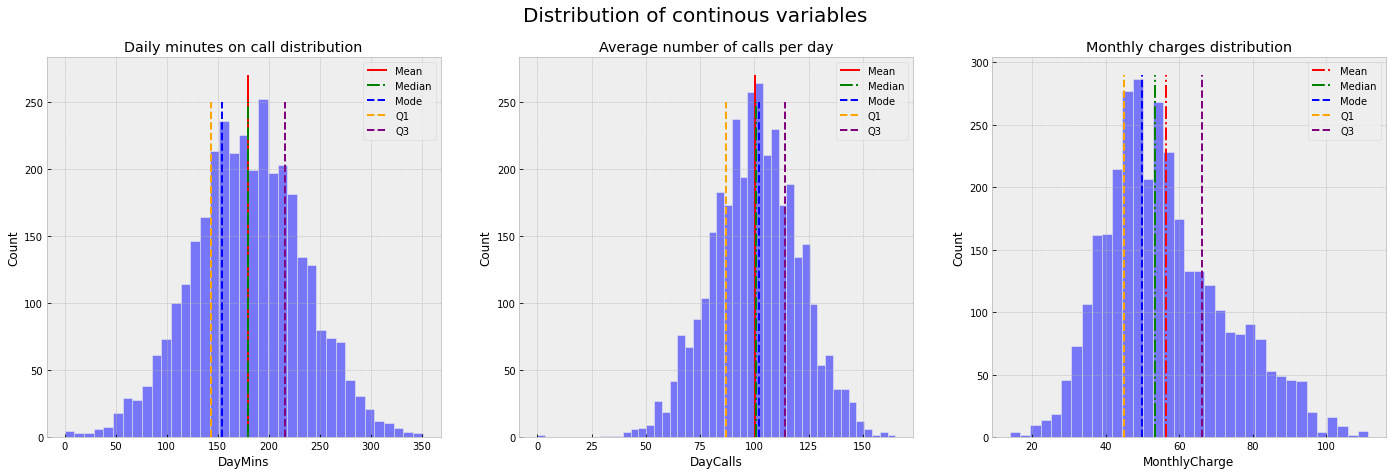

In [33]:
fig, ax = plt.subplots( 1,3, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['DayMins'], ax=ax[0], alpha = 0.5)
ax[0].set_title('Daily minutes on call distribution')
ax[0].vlines(data['DayMins'].mean(),0,270,color='red',label='Mean' , linestyles='solid')
ax[0].vlines(data['DayMins'].median(),0,250,color='green',label='Median', linestyles='dashdot')
ax[0].vlines(data['DayMins'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['DayMins'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['DayMins'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();

sns.histplot(data['DayCalls'], ax=ax[1], alpha = 0.5);
ax[1].set_title('Average number of calls per day')
ax[1].vlines(data['DayCalls'].mean(),0,270,color='red',label='Mean' , linestyles='solid')
ax[1].vlines(data['DayCalls'].median(),0,250,color='green',label='Median', linestyles='dashdot')
ax[1].vlines(data['DayCalls'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['DayCalls'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['DayCalls'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();

sns.histplot(data['MonthlyCharge'], ax=ax[2], alpha = 0.5);
ax[2].set_title('Monthly charges distribution')
ax[2].vlines(data['MonthlyCharge'].mean(),0,290,color='red',label='Mean' , linestyles='dashdot')
ax[2].vlines(data['MonthlyCharge'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[2].vlines(data['MonthlyCharge'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[2].vlines(data['MonthlyCharge'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[2].vlines(data['MonthlyCharge'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[2].legend();

- 75 percent of users spend at least 2 hours per day on the phone.
- On average users calls 56 times per day. It's seems rather high number. I wonder if it's possible to have so many calls per day.
- On average customers are paying 56 dollars per month. Most customers are paying between 45 and 65 dollars per month.

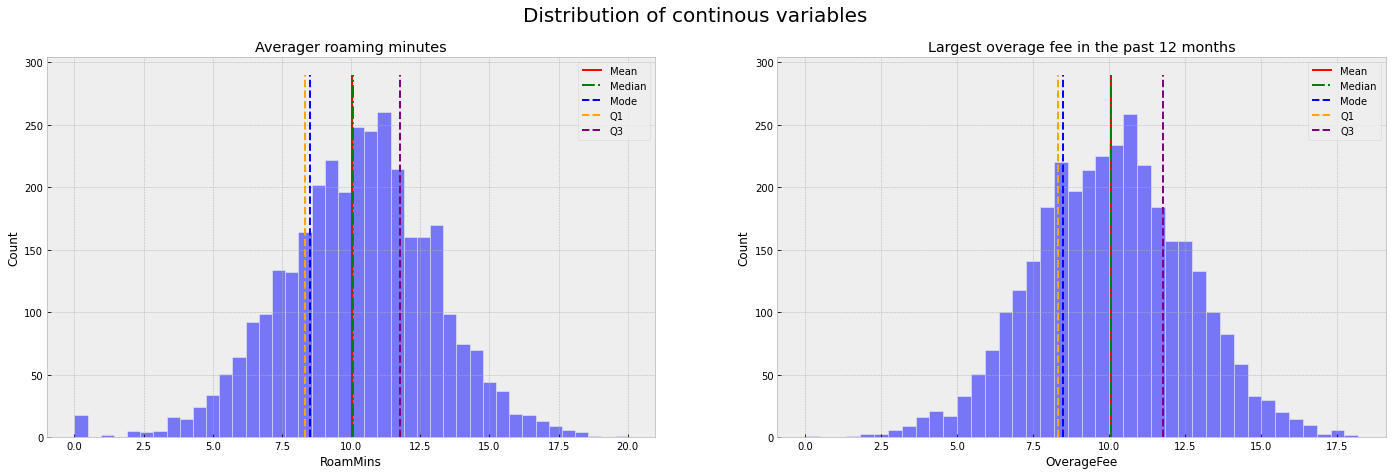

In [34]:
fig, ax = plt.subplots( 1,2, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['RoamMins'], ax = ax[0], alpha = 0.5);
ax[0].set_title('Averager roaming minutes')
ax[0].vlines(data['OverageFee'].mean(),0,290,color='red',label='Mean' , linestyles='solid')
ax[0].vlines(data['OverageFee'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[0].vlines(data['OverageFee'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['OverageFee'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['OverageFee'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();


sns.histplot(data['OverageFee'], ax = ax[1], alpha = 0.5);
ax[1].set_title('Largest overage fee in the past 12 months')
ax[1].vlines(data['OverageFee'].mean(),0,290,color='red',label='Mean' , linestyles='solid')
ax[1].vlines(data['OverageFee'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[1].vlines(data['OverageFee'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['OverageFee'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['OverageFee'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();

- Users on average spend 10 minutes on roaming.
- Interestingly most users exceed agreed amount of minutes and pay overage Fee. On average they pay 10 extra dollars. 

### Relationships

#### Length of being a client

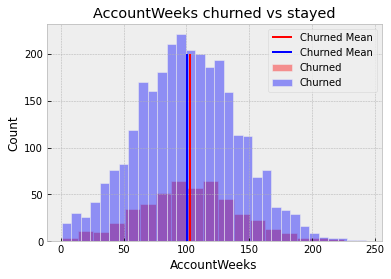

In [35]:
plt.title('AccountWeeks churned vs stayed')
sns.histplot(data[data.Churn == 1]['AccountWeeks'], label='Churned', color='red', alpha = 0.4)
plt.vlines(data[data.Churn == 1]['AccountWeeks'].mean(), 0, 200, color='red', label='Churned Mean')

sns.histplot(data[data.Churn == 0]['AccountWeeks'], label='Churned', color='blue',alpha = 0.4)
plt.vlines(data[data.Churn == 0]['AccountWeeks'].mean(), 0, 200, color='blue', label='Churned Mean')
plt.legend()

Timing in which users churn seems to be unralted to length of the period of being a customer.

#### Customer service calls and  churn

In [ ]:
three_calls = data[data['CustServCalls'] > 2] # 3,4,5, 6,7,8,9
four_calls = data[data['CustServCalls'] > 3] # 4,5, 6,7,8,9
five_calls = data[data['CustServCalls'] > 4] # 5, 6,7,8,9
six_calls = data[data['CustServCalls'] > 5] #  6,7,8,9
data['CustServCalls'].value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: CustServCalls, dtype: int64

In [ ]:
print(f"Churn rate in three or more calls group: {round(len(three_calls[three_calls['Churn'] == 1]) / len(three_calls),2)}, Churn rate in four or more calls group:  {round(len(four_calls[four_calls['Churn'] == 1]) / len(four_calls),2)}.")

Churn rate in three or more calls group: 0.26, Churn rate in four or more calls group:  0.52.


In [ ]:
print(f"Churn rate in five or more calls group: {round(len(five_calls[five_calls['Churn'] == 1]) / len(five_calls),2)}, Churn rate in six or more calls group: {round(len(six_calls[six_calls['Churn'] == 1]) / len(six_calls),2)}")

Churn rate in five or more calls group: 0.61, Churn rate in six or more calls group: 0.63


## Baseline models for churn classification

I have started with data preparation. I used scikit learn Columntransformer to standard scale continuous variable sand one hot encode categorical variables. This transformation I used for all the models with exception to t-sne modelling, but more about that later. 

### Baseline models

![image](charts/baseline_models_accuracy.png)

Most models had high accuracy score. The best models were scikit learn Multilayer perceptron, Random Forest and XGBoost. Although other metrics were not so good. Quadratic Discriminant Analysis had the worst accuracy

![image](charts/baseline_precision.png)

Precision is the most important metric for my model because we want to minimize false positives. So we don't spend resources on users that are not likely to churn. The best model was Linear Support Vector Machines and the worst again QDA.

![image](charts/baseline_recall.png)

Surprisingly, the best model was QDA. It had the best recall score. The worst model was Naive Bayes.

![image](charts/baseline_f1score.png)

F1 score is the harmonic mean of precision and recall. The best model was Neural network, Random Forest and XGBoost. The worst model was Naive Bayes.

![image](charts/baseline_roc.png)

Naive Bayes scored the lowest ROC AUC score. The best model was Neural network, Random Forest and XGBoost.

## Dimensionality reduction

### PCA

Performing principal component analysis on the data proved that 6 components explain almost 100% of the variance. Results made me think how dimensionality reduction influence models.

In [ ]:
from sklearn.decomposition import PCA

pca =PCA(n_components=6, random_state=42)
pca.fit(data)

pca.explained_variance_ratio_

array([0.58352212, 0.30258468, 0.07667953, 0.03427105, 0.00147165,
       0.00109944])

In [ ]:
np.sum([0.58352212, 0.30258468, 0.07667953, 0.03427105, 0.00147165,
       0.00109944]) # explained variance ration summed up

0.9996284700000001

### T-sne models

Later on, I decide to use t-sne on the data and see how much information I lose and if I can visualize multidimensionality of the data. I used 2 components and perplexity equal to 30. 

e:\anaconda\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
e:\anaconda\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3333 samples in 0.008s...
[t-SNE] Computed neighbors for 3333 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3333
[t-SNE] Computed conditional probabilities for sample 2000 / 3333
[t-SNE] Computed conditional probabilities for sample 3000 / 3333
[t-SNE] Computed conditional probabilities for sample 3333 / 3333
[t-SNE] Mean sigma: 11.239228
[t-SNE] Computed conditional probabilities in 0.127s
[t-SNE] Iteration 50: error = 84.2406616, gradient norm = 0.0387337 (50 iterations in 1.085s)
[t-SNE] Iteration 100: error = 74.3116302, gradient norm = 0.0011989 (50 iterations in 0.890s)
[t-SNE] Iteration 150: error = 74.2291183, gradient norm = 0.0000901 (50 iterations in 0.870s)
[t-SNE] Iteration 200: error = 74.2279282, gradient norm = 0.0000912 (50 iterations in 0.778s)
[t-SNE] Iteration 250: error = 74.2277985, gradient norm = 0.0000863 (50 iterations in 0.772s)
[t-SNE] KL divergence after 250 iterat

<AxesSubplot: xlabel='0', ylabel='1'>

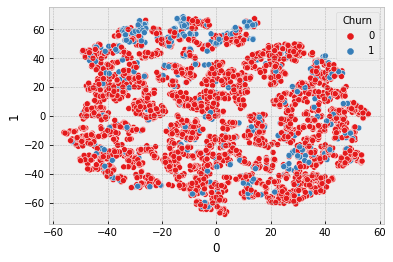

In [ ]:
from sklearn.manifold import TSNE
X , y = data.drop('Churn', axis=1), data['Churn']
c_30 = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X);

tsne_vis = pd.concat([pd.DataFrame(c_30), y], axis=1)

sns.scatterplot(x=tsne_vis.iloc[:,0],y=tsne_vis.iloc[:,1], hue=tsne_vis.Churn, palette='Set1')

Visualization of the data after using various parameters of perplexity weren't very helpful. Above, you can see the visualization of the data with perplexity equal to 30. It's hard to see any valid churn clusters. However, I decided to use this data for modelling.

![image](charts/base_tsne_accuracy.png)

At the first glance, it seems that models perform just a bit worse than on the original data. However, it's not the case. Models perform much worse on the t-sne data. On the next three metrics you can see precision, recall and f1 score. All the models perform much worse on the t-sne data.

![image](charts/baseline_tsne_precision.png)

![image](charts/baseline_tsne_recall.png)

![image](charts/baseline_tsne_f1.png)

T-sne happend to be dead end. I will not use it for further modelling in this project.

## Explainig models

### XGBoost feature importance

![image](charts/xgboost_feature_importance.png)

### SHAP values

![image](charts/xgb_base_shap.png)

I have used inbuilt Xgboost features importance and SHAP values to understand which features are most important for the model. I have used Xgboost model because it was the best overall model in terms of only metrics.
- Feature importance:
    - Information if the customer recently renewed contract is the most important feature. This feature feels a bit of data leakage. Because there is very slim chance that customer will cancel the agreement if couple weeks before he or she signed the contract.
    - Second most important variable is Account weeks. Regular customers are less likely to churn.
    - Users that have called customer service multiple times are more likely to churn.  
    - Monthly billings are the fourth most important variable.
- SHAP values:
    - Interestingly, SHAP values are showing different perspective on the model.
    - Overage fee is the variable that is the most impactful for the model. 
    - Daily time spent talking is the second one.
    - Monthly charges is the third one.

### Best classification models

Best models i have created are voting classifire and Random forest classifire made with **pycaret** low-level mlops library.

#### Voting classifier

To build voting classifire i used scikit learn ensemble models class. I have used Xgboost classfire, GaussianNB and quadratic dyscriminant analysis.

In [4]:
voting = pickle.load(open('models/voting.pkl', 'rb'))    # load the model

e:\anaconda\envs\data_science\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
e:\anaconda\envs\data_science\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(
e:\anaconda\envs\data_science\lib\site-packages\sklearn\discriminant_analysis.py:912: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
e:\anaconda\envs\data_science\lib\site-packages\sklearn\discriminant_analysis.py:912: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
e:\anaconda\envs\data_science\lib\site-packages\sklearn\discriminant_analysis.py:915: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


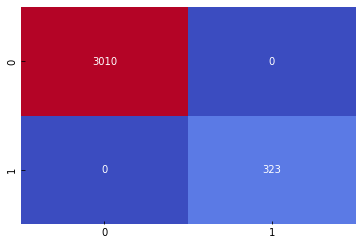

In [12]:
sns.heatmap(confusion_matrix(voting.predict(data_processed.iloc[:,1:]), data_processed.Churn), annot=True, cmap='coolwarm', fmt='g', cbar=False);

Unfortunately, training this model on such a small amount of data leads to overfitting.

#### Pycaret Random forest

In [4]:
from pycaret.classification import *
setup = setup(data, target = 'Churn') # setup the environment

,Description,Value
0,Session id,4231
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(3333, 11)"
4,Transformed data shape,"(3333, 11)"
5,Transformed train set shape,"(2333, 11)"
6,Transformed test set shape,"(1000, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [5]:
best = compare_models(n_select=3) # compare all models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9357,0.9051,0.6476,0.8790,0.7438,0.7081,0.7200,0.1260
gbc,Gradient Boosting Classifier,0.9314,0.9045,0.6355,0.8552,0.7259,0.6880,0.6996,0.2190
lightgbm,Light Gradient Boosting Machine,0.9306,0.8915,0.6357,0.8487,0.7244,0.6859,0.6966,0.0620
xgboost,Extreme Gradient Boosting,0.9288,0.8929,0.6384,0.8334,0.7192,0.6796,0.6896,0.1620
et,Extra Trees Classifier,0.9246,0.8962,0.5854,0.8465,0.6895,0.6485,0.6642,0.1230
ada,Ada Boost Classifier,0.8941,0.8643,0.4586,0.7246,0.5538,0.4978,0.5188,0.0610
dt,Decision Tree Classifier,0.8757,0.7772,0.6387,0.5676,0.5975,0.5248,0.5282,0.0210
ridge,Ridge Classifier,0.8598,0.0000,0.0923,0.6090,0.1563,0.1245,0.1919,0.0180
lr,Logistic Regression,0.8590,0.8070,0.1632,0.5356,0.2472,0.1950,0.2378,0.7960
knn,K Neighbors Classifier,0.8585,0.6312,0.2309,0.5308,0.3167,0.2528,0.2817,0.0360


In [6]:
rf = best[0] # chosing random forest

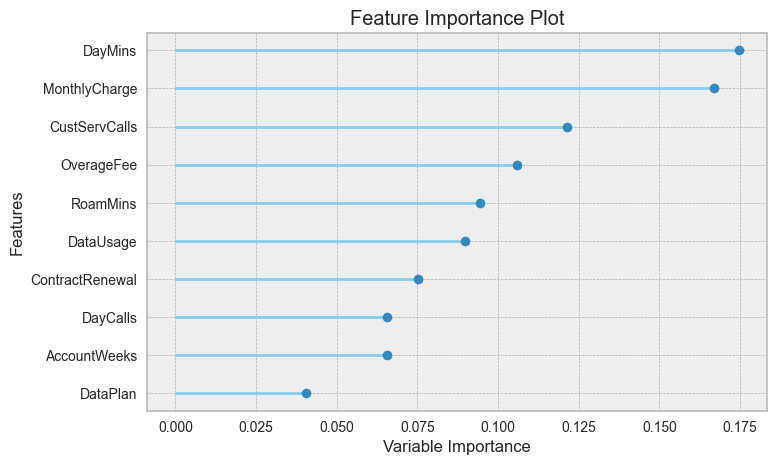

In [7]:
plot_model(rf, plot = 'feature') # feature importance

In [15]:
import pycaret
pycaret.classification.evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

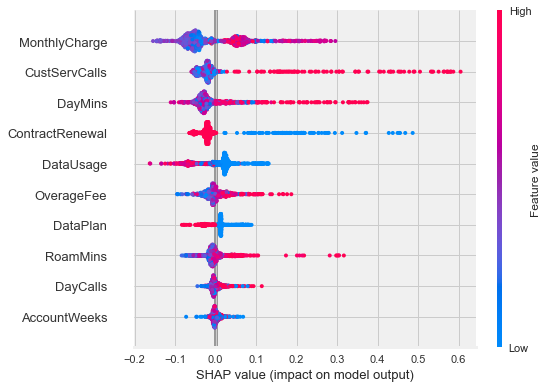

In [14]:
pycaret.classification.interpret_model(rf)

In [16]:
pycaret.classification.save_model(rf, 'models/rf')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\KRZYSZ~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AccountWeeks', 'ContractRenewal',
                                              'DataPlan', 'DataUsage',
                                              'CustServCalls', 'DayMins',
                                              'DayCalls', 'MonthlyCharge',
                                              'OverageFee', 'RoamMins'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=Non...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_feature

## Uplift models

Later on, I decide to try my hands on uplift modelling. So I scikit-uplift library [(sklift)](https://www.uplift-modeling.com/en/latest/#) for that purpose. 
I started with assumption that I cooperated with marketing department, and we decided to ran small discount for contract renewal for investigation use.


This project concluded in increase in contract renewal by 2 percent. Of course, I had to simulate that data by sampling from the original dataset.

In [4]:
# Data creation
contract_ren_1 = data[data['ContractRenewal'] == 1]
contract_ren_0 = data[data['ContractRenewal'] == 0]

s = 3333 # sample size

ratio = 0.92 # 92% renewal rate
ren =round(s *ratio) # renewed customers
not_ren = 3333 - 3066 # non-renewed customers

ren_sample = contract_ren_1.sample(n =ren, random_state=42, replace = True) # sample 3066 customers from the renewed customers
not_ren_sample = contract_ren_0.sample(n =not_ren, random_state=42, replace = True) # sample 3066 customers from the non-renewed customers

print(ren_sample.shape, not_ren_sample.shape)

fabricated = pd.concat([ren_sample, not_ren_sample], axis=0) # concat the two samples

(3066, 11) (267, 11)


In [5]:
data['campaing'] = 0 # original data
fabricated['campaing'] = 1 # fabricated data after supposed campiang increasing renewal rate

merged_data = pd.concat([data, fabricated], axis=0)
merged_data.head(2)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,campaing
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,0


Skilift library provides multiple takes to modelling. I have used so-called two model approach.

[10:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "iterations", "silent", "thread_count" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "iterations", "silent", "thread_count" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




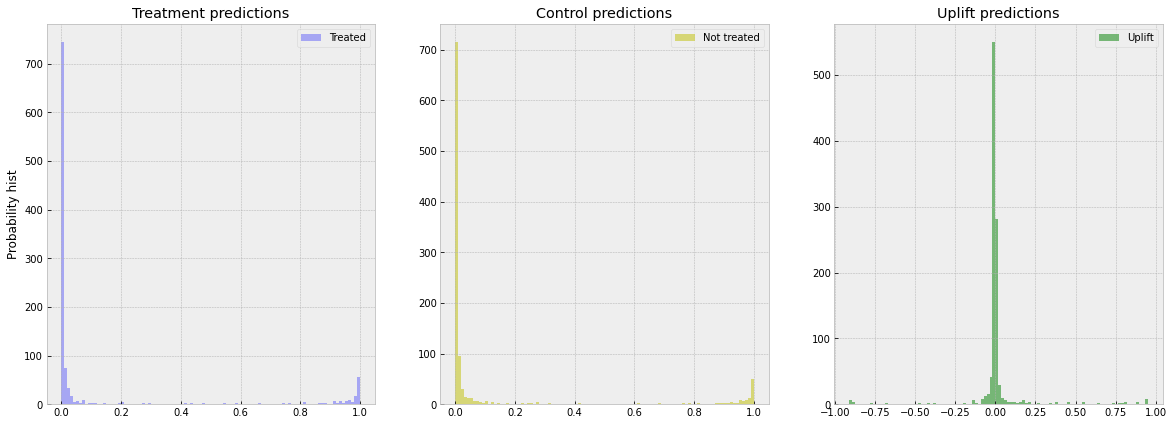

In [6]:
# Uplift modeling
import sklift
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from xgboost import XGBClassifier
from sklift.viz import plot_uplift_preds

# split the data
X_train, X_test, y_train, y_test = train_test_split(merged_data.iloc[:,1:],merged_data.Churn, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

# split the data into control and treatment groups
treat_train = X_train['campaing']
cat_features = ['ContractRenewal','DataPlan']
treat_val = X_valid['campaing']

models_results = {
    'approach': [],
    'uplift@30%': []
}

# model initilization
tm = TwoModels(
    estimator_trmnt=XGBClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=XGBClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

# fit the model
tm = tm.fit(
    X_train, y_train, treat_train)

# predict
uplift_tm = tm.predict(X_valid)

tm_score = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

As you can see uplift predictions barely have any effect on the churn. Different campaigns are adviced since althought we increased renewal rate it doesn't makes our customers less likely to withdraw from agreements. Another thing is in my simulation I haven't tried to target any particular group. This might have huge impact on the uplift. 

## Take out

**- What are the most important features that are related to churn?**


- Customer calls is reliable indicator of customer satisfaction and the customers that makes lot of calls are more likeli to churn.
- Contract renewal seems to be pretty self explanatory, but can be tricky as seen in the uplift modelling. As we can increse signing rate while at the same time not reducing contract termination.
- Models are also finding daily minutes and Monthly charges as important variables but i haven't find prove for that so I cant say if it's overfitting or more comlex relationship. Further analysis is adviced.

**- Can we build a model that will predict churn?**

- Since the dataset is small models tend to overfit. Another problem was the imbalanced dataset which made models have either very high precision or recall.
- Nevertheless it's possible with satisfactory results.
- Best models are **Ensemble Voting Model** consisting of XgboostClassifire, Naive Bayes and QDA. Cons of the model is that it's overfitted so it might not generalize to well.
- Safer option is pycaret **Random Forest**. Accuracy: 93%, Recall: 65%, Precision: 88%. 

**- Can we learn which feature change to provide better service for customers and have higher retain rate?**


- Although my uplifting model didn't prove to be effective way of increasing retain rate. I doubt there none way to do it but that's something that i need to rethink. I nedd to come back to thhis problem with fresh head. 

**- What action should be taken to prevent churn?**

- Increasing signing rate is not the same as increasing retaing rate.
- Perhaps causal modelling or bayesian analysis can prove as more efficient way to finding with features are not only correlated but also causaly associated.